<a href="https://colab.research.google.com/github/ForniLucas/PointerNetwork/blob/main/PointerNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Certainly! Let's consider an example involving natural language processing (NLP), specifically, a simple language translation task.

**Task**: Translate English sentences to French.

**Example**:

- **Input**: "Hello, how are you?"
- **Output (Desired)**: "Bonjour, comment ça va ?"

Now, let's break down how an encoder processes this input:

1. **Input Representation**:
   - Each word in the input sentence needs to be converted into a numerical format that can be fed into a neural network. This is typically done using techniques like word embedding (e.g., Word2Vec, GloVe), where words are mapped to high-dimensional vectors.

   - For example, "Hello," "how," "are," and "you?" might be represented as:
     - "Hello" → [0.2, -0.5, 0.8]
     - "how" → [0.6, 0.1, -0.3]
     - "are" → [0.4, -0.2, 0.7]
     - "you?" → [0.3, -0.4, 0.9]

2. **Sequence Encoding**:
   - The encoder, which could be an LSTM or GRU, takes in these word vectors one at a time. It processes them sequentially, maintaining a hidden state that evolves with each input.

   - For instance, it starts with "Hello":
     - The word vector for "Hello" is fed in.
     - The LSTM updates its hidden state based on this input and its previous hidden state.
     - The updated hidden state is then used as context for processing the next word.

3. **Hidden States**:
   - As the encoder processes each word, it maintains a hidden state that encodes information about the sequence up to that point. This hidden state represents the evolving context of the input sequence.

   - For example, after processing "Hello," the hidden state might be:
     - Hidden State: [0.2, -0.1, 0.6]

4. **Final Hidden State** (Optional):
   - If we're interested in summarizing the entire input sequence, we would extract the final hidden state after processing the entire sequence.

   - This final hidden state is a context-aware representation of the entire input sequence.

   - For example, after processing the entire input sentence, the final hidden state might be:
     - Final Hidden State: [0.8, -0.5, 0.4]

This final hidden state can be used as a representation of the entire input sentence, which can then be used for further processing in the translation task.

In summary, the encoder processes the input sequence by converting each element (in this case, words) into numerical vectors, and then sequentially updates its hidden state based on these inputs. This hidden state encodes the context of the entire sequence, which is crucial for generating accurate translations in this example.



Certainly! Let's consider an example of the Traveling Salesman Problem (TSP) using a pointer network. In this problem, the input is a set of cities, and the goal is to find the shortest path that visits each city exactly once and returns to the starting city.

Suppose we have the following cities, represented as 2D coordinates:

1. City A: (0, 0)
2. City B: (3, 1)
3. City C: (1, 3)
4. City D: (4, 4)

**Input** (Vector of Cities):
```
[
  (0, 0),   # City A
  (3, 1),   # City B
  (1, 3),   # City C
  (4, 4)    # City D
]
```

**Encoder Process** (using an LSTM-based encoder):

1. **Prepare Input Sequences**:
   - Each city's coordinates are converted into a feature vector. For example, you could flatten the coordinates to get a 1D vector.

2. **Create Input Tensor**:
   - The input tensor will be of shape `(seq_len, input_dim)`, where `seq_len` is the number of cities (in this case, 4) and `input_dim` is the dimensionality of each city's representation (2 in this case, for x and y coordinates).

   ```
   Input Tensor:
   [
    [0, 0],   # City A
    [3, 1],   # City B
    [1, 3],   # City C
    [4, 4]    # City D
   ]
   ```

3. **Initialize Hidden State**:
   - Initialize the hidden state of the LSTM.

4. **Pass through the Encoder**:
   - The input tensor is passed through the LSTM. At each time step (corresponding to a city), the LSTM processes the input and updates its hidden state.

   ```
   Hidden States:
   [
    [h1_A, h2_A],   # Hidden state after processing City A
    [h1_B, h2_B],   # Hidden state after processing City B
    [h1_C, h2_C],   # Hidden state after processing City C
    [h1_D, h2_D]    # Hidden state after processing City D
   ]
   ```

5. **Final Hidden State**:
   - If you want to summarize the entire input sequence, you can use the final hidden state, which captures information about all the cities.

   ```
   Final Hidden State:
   [h1_final, h2_final]
   ```

**Output** (Context-Aware Representations):
The output of the encoder is the set of context-aware representations for each city. These representations encode information about the cities in the context of the entire sequence.

```
[
 [h1_A, h2_A],   # Context for City A
 [h1_B, h2_B],   # Context for City B
 [h1_C, h2_C],   # Context for City C
 [h1_D, h2_D]    # Context for City D
]
```

These context-aware representations will be used in conjunction with the attention and pointer mechanisms in the subsequent stages of the pointer network to generate the output sequence, which would be the ordered list of cities representing the optimal tour in the TSP.

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import itertools
from tqdm import tqdm


def tsp_opt(points):
    """
    Dynamic programing solution for TSP - O(2^n*n^2)
    https://gist.github.com/mlalevic/6222750

    :param points: List of (x, y) points
    :return: Optimal solution
    """

    def length(x_coord, y_coord):
        return np.linalg.norm(np.asarray(x_coord) - np.asarray(y_coord))

    # Calculate all lengths
    all_distances = [[length(x, y) for y in points] for x in points]
    # Initial value - just distance from 0 to every other point + keep the track of edges
    A = {(frozenset([0, idx+1]), idx+1): (dist, [0, idx+1]) for idx, dist in enumerate(all_distances[0][1:])}
    cnt = len(points)
    for m in range(2, cnt):
        B = {}
        for S in [frozenset(C) | {0} for C in itertools.combinations(range(1, cnt), m)]:
            for j in S - {0}:
                # This will use 0th index of tuple for ordering, the same as if key=itemgetter(0) used
                B[(S, j)] = min([(A[(S-{j}, k)][0] + all_distances[k][j], A[(S-{j}, k)][1] + [j])
                                 for k in S if k != 0 and k != j])
        A = B
    res = min([(A[d][0] + all_distances[0][d[1]], A[d][1]) for d in iter(A)])
    return np.asarray(res[1])


class TSPDataset(Dataset):
    """
    Random TSP dataset

    """

    def __init__(self, data_size, seq_len, solver=tsp_opt, solve=True):
        self.data_size = data_size
        self.seq_len = seq_len
        self.solve = solve
        self.solver = solver
        self.data = self._generate_data()

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        tensor = torch.from_numpy(self.data['Points_List'][idx]).float()
        solution = torch.from_numpy(self.data['Solutions'][idx]).long() if self.solve else None

        sample = {'Points':tensor, 'Solution':solution}

        return sample

    def _generate_data(self):
        """
        :return: Set of points_list ans their One-Hot vector solutions
        """
        points_list = []
        solutions = []
        data_iter = tqdm(range(self.data_size), unit='data')
        for i, _ in enumerate(data_iter):
            data_iter.set_description('Data points %i/%i' % (i+1, self.data_size))
            points_list.append(np.random.random((self.seq_len, 2)))
        solutions_iter = tqdm(points_list, unit='solve')
        if self.solve:
            for i, points in enumerate(solutions_iter):
                solutions_iter.set_description('Solved %i/%i' % (i+1, len(points_list)))
                solutions.append(self.solver(points))
        else:
            solutions = None

        return {'Points_List':points_list, 'Solutions':solutions}

    def _to1hotvec(self, points):
        """
        :param points: List of integers representing the points indexes
        :return: Matrix of One-Hot vectors
        """
        vec = np.zeros((len(points), self.seq_len))
        for i, v in enumerate(vec):
            v[points[i]] = 1

        return vec

In [ ]:
def test_tsp_opt():
    points = [(0, 0), (1, 3), (5, 2), (4, 1)]
    result = tsp_opt(points)
    print("Ruta optima:", result)

def test_TSPDataset():
    data_size = 5
    seq_len = 4
    dataset = TSPDataset(data_size, seq_len)
    for i in range(data_size):
        sample = dataset[i]
        print(f"Muestra {i+1}:")
        print("Ciudades:")
        print(sample['Points'])
        print("Solucion:")
        print(sample['Solution'])







In [ ]:
test_tsp_opt()

Ruta optima: [0 3 2 1]


In [ ]:
test_TSPDataset()

Solved 5/5: 100%|██████████| 5/5 [00:00<00:00, 493.30solve/s]

Muestra 1:
Ciudades:
tensor([[0.9573, 0.9158],
        [0.0410, 0.7413],
        [0.4997, 0.0592],
        [0.6350, 0.2792]])
Solucion:
tensor([0, 1, 2, 3])
Muestra 2:
Ciudades:
tensor([[0.2345, 0.0805],
        [0.5295, 0.0614],
        [0.7411, 0.7521],
        [0.3599, 0.5998]])
Solucion:
tensor([0, 3, 2, 1])
Muestra 3:
Ciudades:
tensor([[0.6946, 0.2228],
        [0.8033, 0.8572],
        [0.1284, 0.2217],
        [0.9155, 0.6921]])
Solucion:
tensor([0, 2, 1, 3])
Muestra 4:
Ciudades:
tensor([[0.9500, 0.7280],
        [0.5487, 0.2955],
        [0.1000, 0.7382],
        [0.3745, 0.7575]])
Solucion:
tensor([0, 1, 2, 3])
Muestra 5:
Ciudades:
tensor([[0.8605, 0.2325],
        [0.3823, 0.8207],
        [0.5898, 0.5978],
        [0.2999, 0.5119]])
Solucion:
tensor([0, 2, 1, 3])


In [ ]:
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F


class Encoder(nn.Module):
    """
    Encoder class for Pointer-Net
    """

    def __init__(self, embedding_dim,
                 hidden_dim,
                 n_layers,
                 dropout,
                 bidir):
        """
        Initiate Encoder

        :param Tensor embedding_dim: Number of embbeding channels
        :param int hidden_dim: Number of hidden units for the LSTM
        :param int n_layers: Number of layers for LSTMs
        :param float dropout: Float between 0-1
        :param bool bidir: Bidirectional
        """

        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim//2 if bidir else hidden_dim
        self.n_layers = n_layers*2 if bidir else n_layers
        self.bidir = bidir
        self.lstm = nn.LSTM(embedding_dim,
                            self.hidden_dim,
                            n_layers,
                            dropout=dropout,
                            bidirectional=bidir)

        # Used for propagating .cuda() command
        self.h0 = Parameter(torch.zeros(1), requires_grad=False)
        self.c0 = Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, embedded_inputs,
                hidden):
        """
        Encoder - Forward-pass

        :param Tensor embedded_inputs: Embedded inputs of Pointer-Net
        :param Tensor hidden: Initiated hidden units for the LSTMs (h, c)
        :return: LSTMs outputs and hidden units (h, c)
        """

        embedded_inputs = embedded_inputs.permute(1, 0, 2)

        outputs, hidden = self.lstm(embedded_inputs, hidden)

        return outputs.permute(1, 0, 2), hidden

    def init_hidden(self, embedded_inputs):
        """
        Initiate hidden units

        :param Tensor embedded_inputs: The embedded input of Pointer-NEt
        :return: Initiated hidden units for the LSTMs (h, c)
        """

        batch_size = embedded_inputs.size(0)

        # Reshaping (Expanding)
        h0 = self.h0.unsqueeze(0).unsqueeze(0).repeat(self.n_layers,
                                                      batch_size,
                                                      self.hidden_dim)
        c0 = self.h0.unsqueeze(0).unsqueeze(0).repeat(self.n_layers,
                                                      batch_size,
                                                      self.hidden_dim)

        return h0, c0


class Attention(nn.Module):
    """
    Attention model for Pointer-Net
    """

    def __init__(self, input_dim,
                 hidden_dim):
        """
        Initiate Attention

        :param int input_dim: Input's diamention
        :param int hidden_dim: Number of hidden units in the attention
        """

        super(Attention, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.context_linear = nn.Conv1d(input_dim, hidden_dim, 1, 1)
        self.V = Parameter(torch.FloatTensor(hidden_dim), requires_grad=True)
        self._inf = Parameter(torch.FloatTensor([float('-inf')]), requires_grad=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()

        # Initialize vector V
        nn.init.uniform(self.V, -1, 1)

    def forward(self, input,
                context,
                mask):
        """
        Attention - Forward-pass

        :param Tensor input: Hidden state h
        :param Tensor context: Attention context
        :param ByteTensor mask: Selection mask
        :return: tuple of - (Attentioned hidden state, Alphas)
        """

        # (batch, hidden_dim, seq_len)
        inp = self.input_linear(input).unsqueeze(2).expand(-1, -1, context.size(1))

        # (batch, hidden_dim, seq_len)
        context = context.permute(0, 2, 1)
        ctx = self.context_linear(context)

        # (batch, 1, hidden_dim)
        V = self.V.unsqueeze(0).expand(context.size(0), -1).unsqueeze(1)

        # (batch, seq_len)
        att = torch.bmm(V, self.tanh(inp + ctx)).squeeze(1)
        if len(att[mask]) > 0:
            att[mask] = self.inf[mask]
        alpha = self.softmax(att)

        hidden_state = torch.bmm(ctx, alpha.unsqueeze(2)).squeeze(2)

        return hidden_state, alpha

    def init_inf(self, mask_size):
        self.inf = self._inf.unsqueeze(1).expand(*mask_size)


class Decoder(nn.Module):
    """
    Decoder model for Pointer-Net
    """

    def __init__(self, embedding_dim,
                 hidden_dim):
        """
        Initiate Decoder

        :param int embedding_dim: Number of embeddings in Pointer-Net
        :param int hidden_dim: Number of hidden units for the decoder's RNN
        """

        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.input_to_hidden = nn.Linear(embedding_dim, 4 * hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, 4 * hidden_dim)
        self.hidden_out = nn.Linear(hidden_dim * 2, hidden_dim)
        self.att = Attention(hidden_dim, hidden_dim)

        # Used for propagating .cuda() command
        self.mask = Parameter(torch.ones(1), requires_grad=False)
        self.runner = Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, embedded_inputs,
                decoder_input,
                hidden,
                context):
        """
        Decoder - Forward-pass

        :param Tensor embedded_inputs: Embedded inputs of Pointer-Net
        :param Tensor decoder_input: First decoder's input
        :param Tensor hidden: First decoder's hidden states
        :param Tensor context: Encoder's outputs
        :return: (Output probabilities, Pointers indices), last hidden state
        """

        batch_size = embedded_inputs.size(0)
        input_length = embedded_inputs.size(1)

        # (batch, seq_len)
        mask = self.mask.repeat(input_length).unsqueeze(0).repeat(batch_size, 1)
        self.att.init_inf(mask.size())

        # Generating arang(input_length), broadcasted across batch_size
        runner = self.runner.repeat(input_length)
        for i in range(input_length):
            runner.data[i] = i
        runner = runner.unsqueeze(0).expand(batch_size, -1).long()

        outputs = []
        pointers = []

        def step(x, hidden):
            """
            Recurrence step function

            :param Tensor x: Input at time t
            :param tuple(Tensor, Tensor) hidden: Hidden states at time t-1
            :return: Hidden states at time t (h, c), Attention probabilities (Alpha)
            """

            # Regular LSTM
            h, c = hidden

            gates = self.input_to_hidden(x) + self.hidden_to_hidden(h)
            input, forget, cell, out = gates.chunk(4, 1)

            input = F.sigmoid(input)
            forget = F.sigmoid(forget)
            cell = F.tanh(cell)
            out = F.sigmoid(out)

            c_t = (forget * c) + (input * cell)
            h_t = out * F.tanh(c_t)

            # Attention section
            hidden_t, output = self.att(h_t, context, torch.eq(mask, 0))
            hidden_t = F.tanh(self.hidden_out(torch.cat((hidden_t, h_t), 1)))

            return hidden_t, c_t, output

        # Recurrence loop
        for _ in range(input_length):
            h_t, c_t, outs = step(decoder_input, hidden)
            hidden = (h_t, c_t)

            # Masking selected inputs
            masked_outs = outs * mask

            # Get maximum probabilities and indices
            max_probs, indices = masked_outs.max(1)
            one_hot_pointers = (runner == indices.unsqueeze(1).expand(-1, outs.size()[1])).float()

            # Update mask to ignore seen indices
            mask  = mask * (1 - one_hot_pointers)

            # Get embedded inputs by max indices
            embedding_mask = one_hot_pointers.unsqueeze(2).expand(-1, -1, self.embedding_dim).byte()
            decoder_input = embedded_inputs[embedding_mask.data].view(batch_size, self.embedding_dim)

            outputs.append(outs.unsqueeze(0))
            pointers.append(indices.unsqueeze(1))

        outputs = torch.cat(outputs).permute(1, 0, 2)
        pointers = torch.cat(pointers, 1)

        return (outputs, pointers), hidden


class PointerNet(nn.Module):
    """
    Pointer-Net
    """

    def __init__(self, embedding_dim,
                 hidden_dim,
                 lstm_layers,
                 dropout,
                 bidir=False):
        """
        Initiate Pointer-Net

        :param int embedding_dim: Number of embbeding channels
        :param int hidden_dim: Encoders hidden units
        :param int lstm_layers: Number of layers for LSTMs
        :param float dropout: Float between 0-1
        :param bool bidir: Bidirectional
        """

        super(PointerNet, self).__init__()
        self.embedding_dim = embedding_dim
        self.bidir = bidir
        self.embedding = nn.Linear(2, embedding_dim)
        self.encoder = Encoder(embedding_dim,
                               hidden_dim,
                               lstm_layers,
                               dropout,
                               bidir)
        self.decoder = Decoder(embedding_dim, hidden_dim)
        self.decoder_input0 = Parameter(torch.FloatTensor(embedding_dim), requires_grad=False)

        # Initialize decoder_input0
        nn.init.uniform(self.decoder_input0, -1, 1)

    def forward(self, inputs):
        """
        PointerNet - Forward-pass

        :param Tensor inputs: Input sequence
        :return: Pointers probabilities and indices
        """

        batch_size = inputs.size(0)
        input_length = inputs.size(1)

        decoder_input0 = self.decoder_input0.unsqueeze(0).expand(batch_size, -1)

        inputs = inputs.view(batch_size * input_length, -1)
        embedded_inputs = self.embedding(inputs).view(batch_size, input_length, -1)

        encoder_hidden0 = self.encoder.init_hidden(embedded_inputs)
        encoder_outputs, encoder_hidden = self.encoder(embedded_inputs,
                                                       encoder_hidden0)
        if self.bidir:
        # Concatenate the last two hidden states of the encoder
          hidden_0 = torch.cat((encoder_hidden[0][-2], encoder_hidden[0][-1]), dim=-1)
          hidden_1 = torch.cat((encoder_hidden[1][-2], encoder_hidden[1][-1]), dim=-1)
          decoder_hidden0 = (hidden_0, hidden_1)
        else:
          decoder_hidden0 = (encoder_hidden[0][-1], encoder_hidden[1][-1])

        (outputs, pointers), decoder_hidden = self.decoder(embedded_inputs,
                                                           decoder_input0,
                                                           decoder_hidden0,
                                                           encoder_outputs)

        return  outputs, pointers

In [ ]:
import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader


# Define training parameters
params = {
    'train_size': 1000,
    'val_size': 100,
    'test_size': 100,
    'batch_size': 256,
    'nof_epoch': 500,
    'lr': 0.0001,
    'gpu': True,
    'nof_points': 5,
    'embedding_size': 128,
    'hiddens': 512,
    'nof_lstms': 2,
    'dropout': 0.,
    'bidir': True
}

# Check if GPU is available
if params['gpu'] and torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
else:
    USE_CUDA = False

# Initialize the model
model = PointerNet(params['embedding_size'],
                   params['hiddens'],
                   params['nof_lstms'],
                   params['dropout'],
                   params['bidir'])

# Initialize dataset and dataloader
dataset = TSPDataset(params['train_size'],
                     params['nof_points'])

dataloader = DataLoader(dataset,
                        batch_size=params['batch_size'],
                        shuffle=True,
                        num_workers=4)

# Move model to GPU if available
if USE_CUDA:
    model.cuda()

# Initialize optimizer and loss function
CCE = torch.nn.CrossEntropyLoss()
model_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                model.parameters()),
                         lr=params['lr'])

# Training loop
for epoch in range(params['nof_epoch']):
    batch_loss = []

    for i_batch, sample_batched in enumerate(dataloader):
        train_batch = Variable(sample_batched['Points'])
        target_batch = Variable(sample_batched['Solution'])

        if USE_CUDA:
            train_batch = train_batch.cuda()
            target_batch = target_batch.cuda()

        o, p = model(train_batch)
        o = o.contiguous().view(-1, o.size()[-1])

        target_batch = target_batch.view(-1)

        loss = CCE(o, target_batch)

        batch_loss.append(loss.item())

        model_optim.zero_grad()
        loss.backward()
        model_optim.step()

    average_loss = sum(batch_loss) / len(batch_loss)
    print(f'Epoch {epoch+1}/{params["nof_epoch"]}, Average Loss: {average_loss:.4f}')

# Save the trained model if needed
# torch.save(model.state_dict(), 'pointer_net_model.pth')


<ipython-input-5-09d66fb904e7>:105: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.V, -1, 1)
<ipython-input-5-09d66fb904e7>:290: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.decoder_input0, -1, 1)


Using GPU, 1 devices.


Solved 1000/1000: 100%|██████████| 1000/1000 [00:01<00:00, 628.07solve/s]
<ipython-input-5-09d66fb904e7>:246: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  decoder_input = embedded_inputs[embedding_mask.data].view(batch_size, self.embedding_dim)
/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:251: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/500, Average Loss: 1.5319
Epoch 2/500, Average Loss: 1.4689
Epoch 3/500, Average Loss: 1.4379
Epoch 4/500, Average Loss: 1.4287
Epoch 5/500, Average Loss: 1.4246
Epoch 6/500, Average Loss: 1.4354
Epoch 7/500, Average Loss: 1.4378
Epoch 8/500, Average Loss: 1.4366
Epoch 9/500, Average Loss: 1.4410
Epoch 10/500, Average Loss: 1.4413
Epoch 11/500, Average Loss: 1.4418
Epoch 12/500, Average Loss: 1.4397
Epoch 13/500, Average Loss: 1.4363
Epoch 14/500, Average Loss: 1.4369
Epoch 15/500, Average Loss: 1.4385
Epoch 16/500, Average Loss: 1.4387
Epoch 17/500, Average Loss: 1.4384
Epoch 18/500, Average Loss: 1.4380
Epoch 19/500, Average Loss: 1.4362
Epoch 20/500, Average Loss: 1.4357
Epoch 21/500, Average Loss: 1.4352
Epoch 22/500, Average Loss: 1.4367
Epoch 23/500, Average Loss: 1.4368
Epoch 24/500, Average Loss: 1.4343
Epoch 25/500, Average Loss: 1.4341
Epoch 26/500, Average Loss: 1.4359
Epoch 27/500, Average Loss: 1.4354
Epoch 28/500, Average Loss: 1.4349
Epoch 29/500, Average Loss: 1

<ipython-input-5-09d66fb904e7>:105: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.V, -1, 1)
<ipython-input-5-09d66fb904e7>:290: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.decoder_input0, -1, 1)


Using GPU, 1 devices.


Solved 1000/1000: 100%|██████████| 1000/1000 [00:01<00:00, 647.18solve/s]
<ipython-input-5-09d66fb904e7>:246: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  decoder_input = embedded_inputs[embedding_mask.data].view(batch_size, self.embedding_dim)


Epoch 1/500, Average Loss: 1.5347
Epoch 2/500, Average Loss: 1.4657
Epoch 3/500, Average Loss: 1.4348
Epoch 4/500, Average Loss: 1.4277
Epoch 5/500, Average Loss: 1.4326
Epoch 6/500, Average Loss: 1.4405
Epoch 7/500, Average Loss: 1.4455
Epoch 8/500, Average Loss: 1.4473
Epoch 9/500, Average Loss: 1.4469
Epoch 10/500, Average Loss: 1.4435
Epoch 11/500, Average Loss: 1.4398
Epoch 12/500, Average Loss: 1.4392
Epoch 13/500, Average Loss: 1.4401
Epoch 14/500, Average Loss: 1.4392
Epoch 15/500, Average Loss: 1.4379
Epoch 16/500, Average Loss: 1.4323
Epoch 17/500, Average Loss: 1.4239
Epoch 18/500, Average Loss: 1.4138
Epoch 19/500, Average Loss: 1.4124
Epoch 20/500, Average Loss: 1.4118
Epoch 21/500, Average Loss: 1.4121
Epoch 22/500, Average Loss: 1.4118
Epoch 23/500, Average Loss: 1.4118
Epoch 24/500, Average Loss: 1.4116
Epoch 25/500, Average Loss: 1.4116
Epoch 26/500, Average Loss: 1.4114
Epoch 27/500, Average Loss: 1.4109
Epoch 28/500, Average Loss: 1.4109
Epoch 29/500, Average Loss: 1

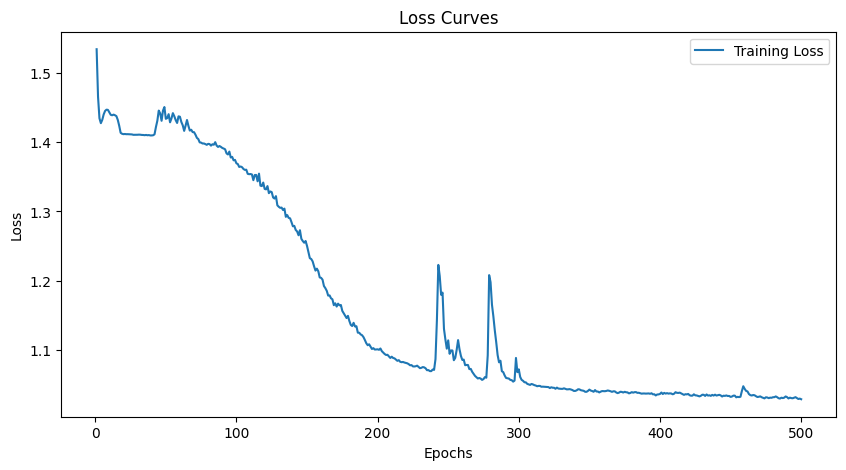

In [ ]:
import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define training parameters
params = {
    'train_size': 1000,
    'val_size': 100,
    'test_size': 100,
    'batch_size': 256,
    'nof_epoch': 500,
    'lr': 0.0001,
    'gpu': True,
    'nof_points': 5,
    'embedding_size': 128,
    'hiddens': 512,
    'nof_lstms': 2,
    'dropout': 0.,
    'bidir': True
}

# Check if GPU is available
if params['gpu'] and torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
else:
    USE_CUDA = False

# Initialize the model
model = PointerNet(params['embedding_size'],
                   params['hiddens'],
                   params['nof_lstms'],
                   params['dropout'],
                   params['bidir'])

# Initialize dataset and dataloader
dataset = TSPDataset(params['train_size'],
                     params['nof_points'])

dataloader = DataLoader(dataset,
                        batch_size=params['batch_size'],
                        shuffle=True,
                        num_workers=4)

# Move model to GPU if available
if USE_CUDA:
    model.cuda()

# Initialize optimizer and loss function
CCE = torch.nn.CrossEntropyLoss()
model_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                model.parameters()),
                         lr=params['lr'])

# Initialize lists to store loss values
train_losses = []
val_losses = []
test_losses = []

# Training loop
for epoch in range(params['nof_epoch']):
    batch_loss = []

    for i_batch, sample_batched in enumerate(dataloader):
        train_batch = Variable(sample_batched['Points'])
        target_batch = Variable(sample_batched['Solution'])

        if USE_CUDA:
            train_batch = train_batch.cuda()
            target_batch = target_batch.cuda()

        o, p = model(train_batch)
        o = o.contiguous().view(-1, o.size()[-1])

        target_batch = target_batch.view(-1)

        loss = CCE(o, target_batch)

        batch_loss.append(loss.item())

        model_optim.zero_grad()
        loss.backward()
        model_optim.step()

    average_loss = sum(batch_loss) / len(batch_loss)
    print(f'Epoch {epoch+1}/{params["nof_epoch"]}, Average Loss: {average_loss:.4f}')

    # Store training loss for plotting
    train_losses.append(average_loss)

    # Optionally, calculate validation and test loss here if you have validation and test datasets
    # val_loss = ...
    # test_loss = ...
    # val_losses.append(val_loss)
    # test_losses.append(test_loss)

# Plot the training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, params['nof_epoch']+1), train_losses, label='Training Loss')
# Optionally, plot validation and test losses if available
# plt.plot(range(1, params['nof_epoch']+1), val_losses, label='Validation Loss')
# plt.plot(range(1, params['nof_epoch']+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Save the trained model if needed
# torch.save(model.state_dict(), 'pointer_net_model.pth')